# HW 2 - Разложение матриц градиентным методом

Цель задания: В ходе реализации [разложения Таккера](https://proceedings.neurips.cc/paper/2018/file/45a766fa266ea2ebeb6680fa139d2a3d-Paper.pdf) градиентным методом освоить pyTorch и реализовать подходы оптимизации параметров модели (в отсутствии готовых решений).

[Более-менее внятное описание алгоритма канонического разложения](https://www.alexejgossmann.com/tensor_decomposition_tucker/)

In [1]:
# Если нет библиотеки tensorly, раскоментируй одну их этих строк
# !pip install -U tensorly
# !conda install -c tensorly tensorly

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import time

from numpy.lib.stride_tricks import as_strided
from tensorly.decomposition import tucker

# from sktensor.core import ttm
# from sktensor.tucker import hooi

# import math
from torch.optim.optimizer import Optimizer

## 1. Ф-ции решающие задачу

In [3]:
def reorder(indices, mode):
    indices = list(indices)
    element = indices.pop(mode)
    return ([element] + indices[::-1])

In [4]:
def my_unfold(tensor, mode=0):
    return tensor.permute(reorder(range(tensor.ndim), mode)).reshape((tensor.shape[mode], -1))

In [5]:
def my_fold(unfolded, mode, shape):
    unfolded_indices = reorder(range(len(shape)), mode)
    original_shape = [shape[i] for i in unfolded_indices]
    unfolded = unfolded.reshape(original_shape)

    folded_indices = list(range(len(shape)-1, 0, -1))
    folded_indices.insert(mode, 0)
    return unfolded.permute(folded_indices)

In [6]:
def repair_torch_tensor(core: torch.Tensor, U: torch.Tensor)-> torch.Tensor:
    data = core
    for i, u in enumerate(U):
        curr_shape = data.shape
        un_folded_data = u @ my_unfold(data, i)  
        shape = [curr_shape[k] if k != i else u.shape[0] for k in range(len(curr_shape))]
        data = my_fold(un_folded_data, i, shape)

    return data

In [7]:
def get_tensor(tensor_size=(100,200,150), r=(10, 20, 30), device="cpu"):
    G = torch.rand(r, device=device) * 9
    U = [
        torch.rand(size=(dim, r_dim), device=device)
        for r_dim, dim in zip(r, tensor_size)
    ]
    
    data = repair_torch_tensor(G, U)
    return data, U, G

In [8]:
def add_noise(tensor, device="cpu"):
    return tensor + 1e-2 * torch.normal(mean=torch.zeros_like(tensor)).to(device)

In [9]:
def MSE(target, predict):
    return torch.mean((target-predict)**2)

In [10]:
class CustomSGD(Optimizer):
    
    def __init__(self, params, lr=1e-5):
        defaults = dict(lr=lr)
        super(CustomSGD, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                p.data -= group['lr'] * grad

## 2. Пример работы

Сгенерируйте тензор и добавьте к нему случайный шум с размерностью *1e-2*

In [11]:
sample_data, U, G = get_tensor(r=(10, 20, 30))
sample_data.shape, [u.shape for u in U], G.shape

(torch.Size([100, 200, 150]),
 [torch.Size([100, 10]), torch.Size([200, 20]), torch.Size([150, 30])],
 torch.Size([10, 20, 30]))

In [12]:
sample_data = add_noise(sample_data)

Вопрос:
Почему задание не имеет смысла для полностью случайного тензора и зачем добавлять шум? *не отвечать нельзя*

Ответ: чтобы сделать решение более устойчивым

## 3. Пример разложения библиотечным методом
Не забудьте померить ошибку разложения по метрике MSE

In [13]:
core, factors = tucker(sample_data.numpy(), (10, 20, 30))
core = torch.tensor(core)
factors = [torch.tensor(factor.copy()) for factor in factors]

In [14]:
data_rep = repair_torch_tensor(core, factors)

In [15]:
MSE(data_rep, sample_data), MSE(core, G)

(tensor(3.6610), tensor(6.0396e+09))

## 4. Градиентный подсчет ядра

In [16]:
TENSOR_SIZE = (300, 200, 100)
RANKS = (10, 20, 30)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

DATA_SIZE = 5
NUM_EPOCHS = 1000

In [17]:
print("Your DEVICE is", DEVICE)

Your DEVICE is cuda


In [18]:
# Generating target tensor
data = []
for i in range(DATA_SIZE):
    tensor, _, _ = get_tensor(TENSOR_SIZE, RANKS, device=DEVICE)
    data += [add_noise(tensor, DEVICE)]

In [19]:
loss_over_data = []
start_time = time.time()
for tensor in data:
    loss_history = []
    
    # Generating initial approximation
    kernel_approx = torch.rand(RANKS, requires_grad=True, device=DEVICE)
    factors_approx = [
        torch.rand(size=(dim, r_dim), requires_grad=True, device=DEVICE)
        for r_dim, dim in zip(RANKS, TENSOR_SIZE)
    ]
    optim = CustomSGD(params=[kernel_approx] + factors_approx, lr=1e-05)
    
    for epoch in tqdm(range(NUM_EPOCHS)):
        optim.zero_grad()

        tensor_approx = repair_torch_tensor(kernel_approx, factors_approx)
        loss = MSE(tensor, tensor_approx)
        loss.backward()

        loss_history += [loss]

        optim.step()
    
    loss_over_data += [loss_history]
end_time = time.time()
grad_mean_time = (end_time-start_time) / DATA_SIZE

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

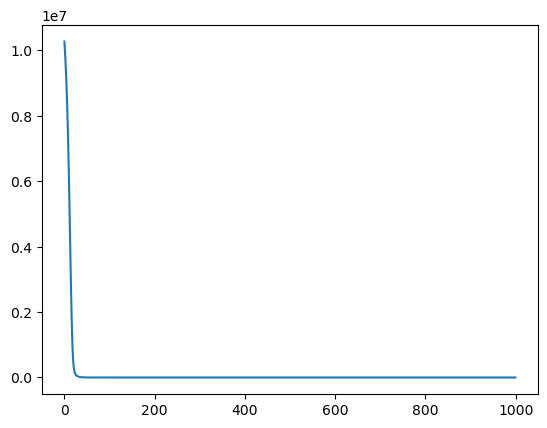

In [20]:
loss_values = [value.detach().to("cpu") for value in loss_over_data[0]]
plt.plot(loss_values)

## 5. Библиотечное разложение

In [21]:
total_time = 0
analitic_loss = []
for tensor in tqdm(data):
    tensor = tensor.to("cpu")
    start_time = time.time()
    core, factors = tucker(tensor.numpy(), RANKS)
    end_time = time.time()
    total_time += end_time-start_time
    
    core = torch.tensor(core)
    factors = [torch.tensor(factor.copy()) for factor in factors]
    tensor_rep = repair_torch_tensor(core, factors)
    
    analitic_loss += [MSE(tensor_rep, tensor)]
analitic_mean_time = total_time / DATA_SIZE

  0%|          | 0/5 [00:00<?, ?it/s]

In [22]:
analitic_mean_loss = sum(analitic_loss) / DATA_SIZE
grad_mean_loss = torch.mean(torch.tensor([loss_over_data[i][-1] for i in range(DATA_SIZE)]))

## 6. Сравнение

In [23]:
print("Средняя ошибка MSE по всем данным:")
print(f"- аналитическое решение   {float(analitic_mean_loss):.4}", )
print(f"- градиентная оптимизация {float(grad_mean_loss):.6}", )

Средняя ошибка MSE по всем данным:
- аналитическое решение   2.459
- градиентная оптимизация 210.343


In [24]:
print("Среднее время работы (сек):")
print(f"- аналитическое решение   {analitic_mean_time:.4}", )
print(f"- градиентная оптимизация {grad_mean_time:.5}", )

Среднее время работы (сек):
- аналитическое решение   0.8098
- градиентная оптимизация 5.0559
